<h2>Packages</h2>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#import statsmodels.api as sm
from statsmodels.compat import lzip
#import statsmodels.stats.api as sms
#from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

<h2>Load Data</h2>

In [5]:
# path = 'forestfires.csv'
path = "forestfires.csv"
df = pd.read_csv(path)
df.shape

(517, 13)

In [ ]:
df.dtypes

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


# Missing value treatment

In [5]:
df.isna().sum().sum()

0

<h2>EDA</h2>

In [6]:
plt.rcParams["figure.figsize"] = 9,5

<h2>Univariate Analysis</h2>

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


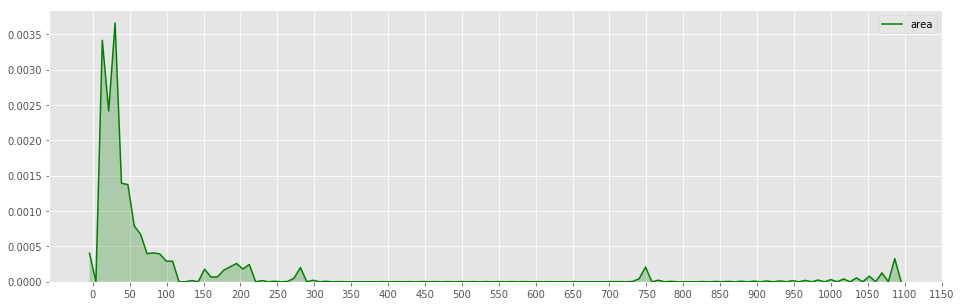

In [8]:
#Area 
target = 'area'
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

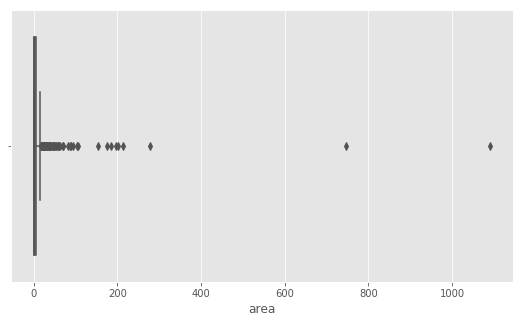

In [9]:
ax = sns.boxplot(df[target])

**observations:**

- The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

- It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

- Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [10]:
# Outlier points
y_outliers = df[abs(zscore(df[target]))>=3]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


In [11]:
#Independent COlumns
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

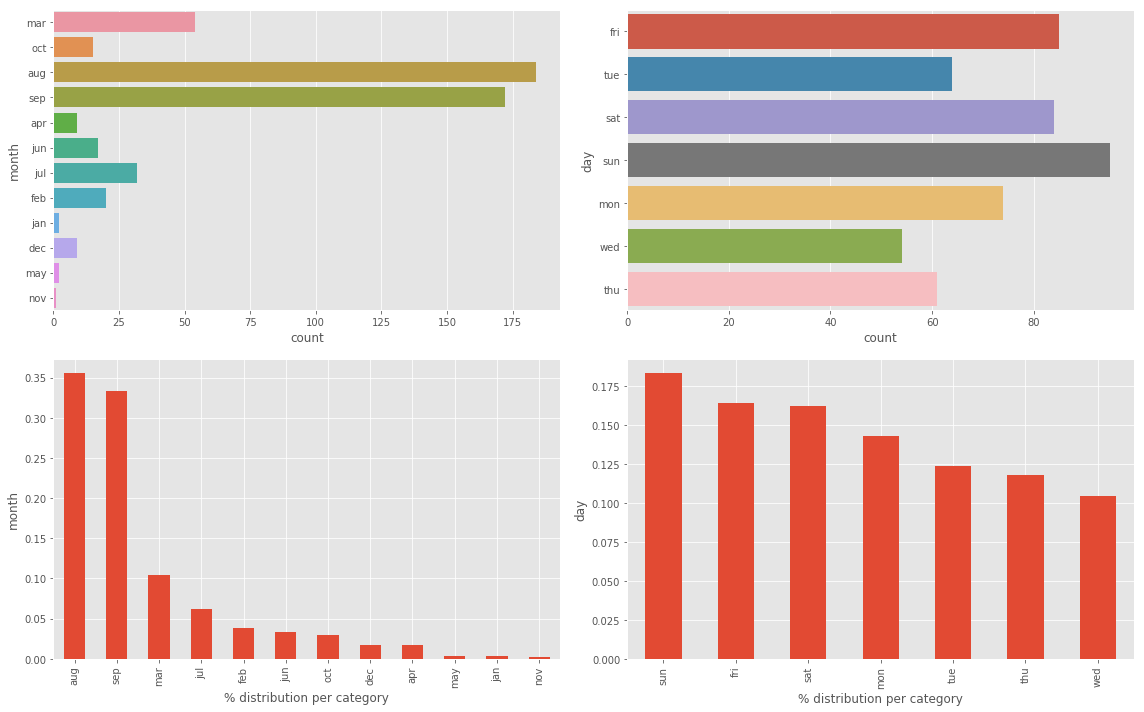

In [12]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show() 

1. It is interesting to see that abnormally high number of the forest fires occur in the month of `August`
and `September`.

2. In the case of day, the days `Friday` to `Monday` have higher proportion of cases. (However, no strong indicators)

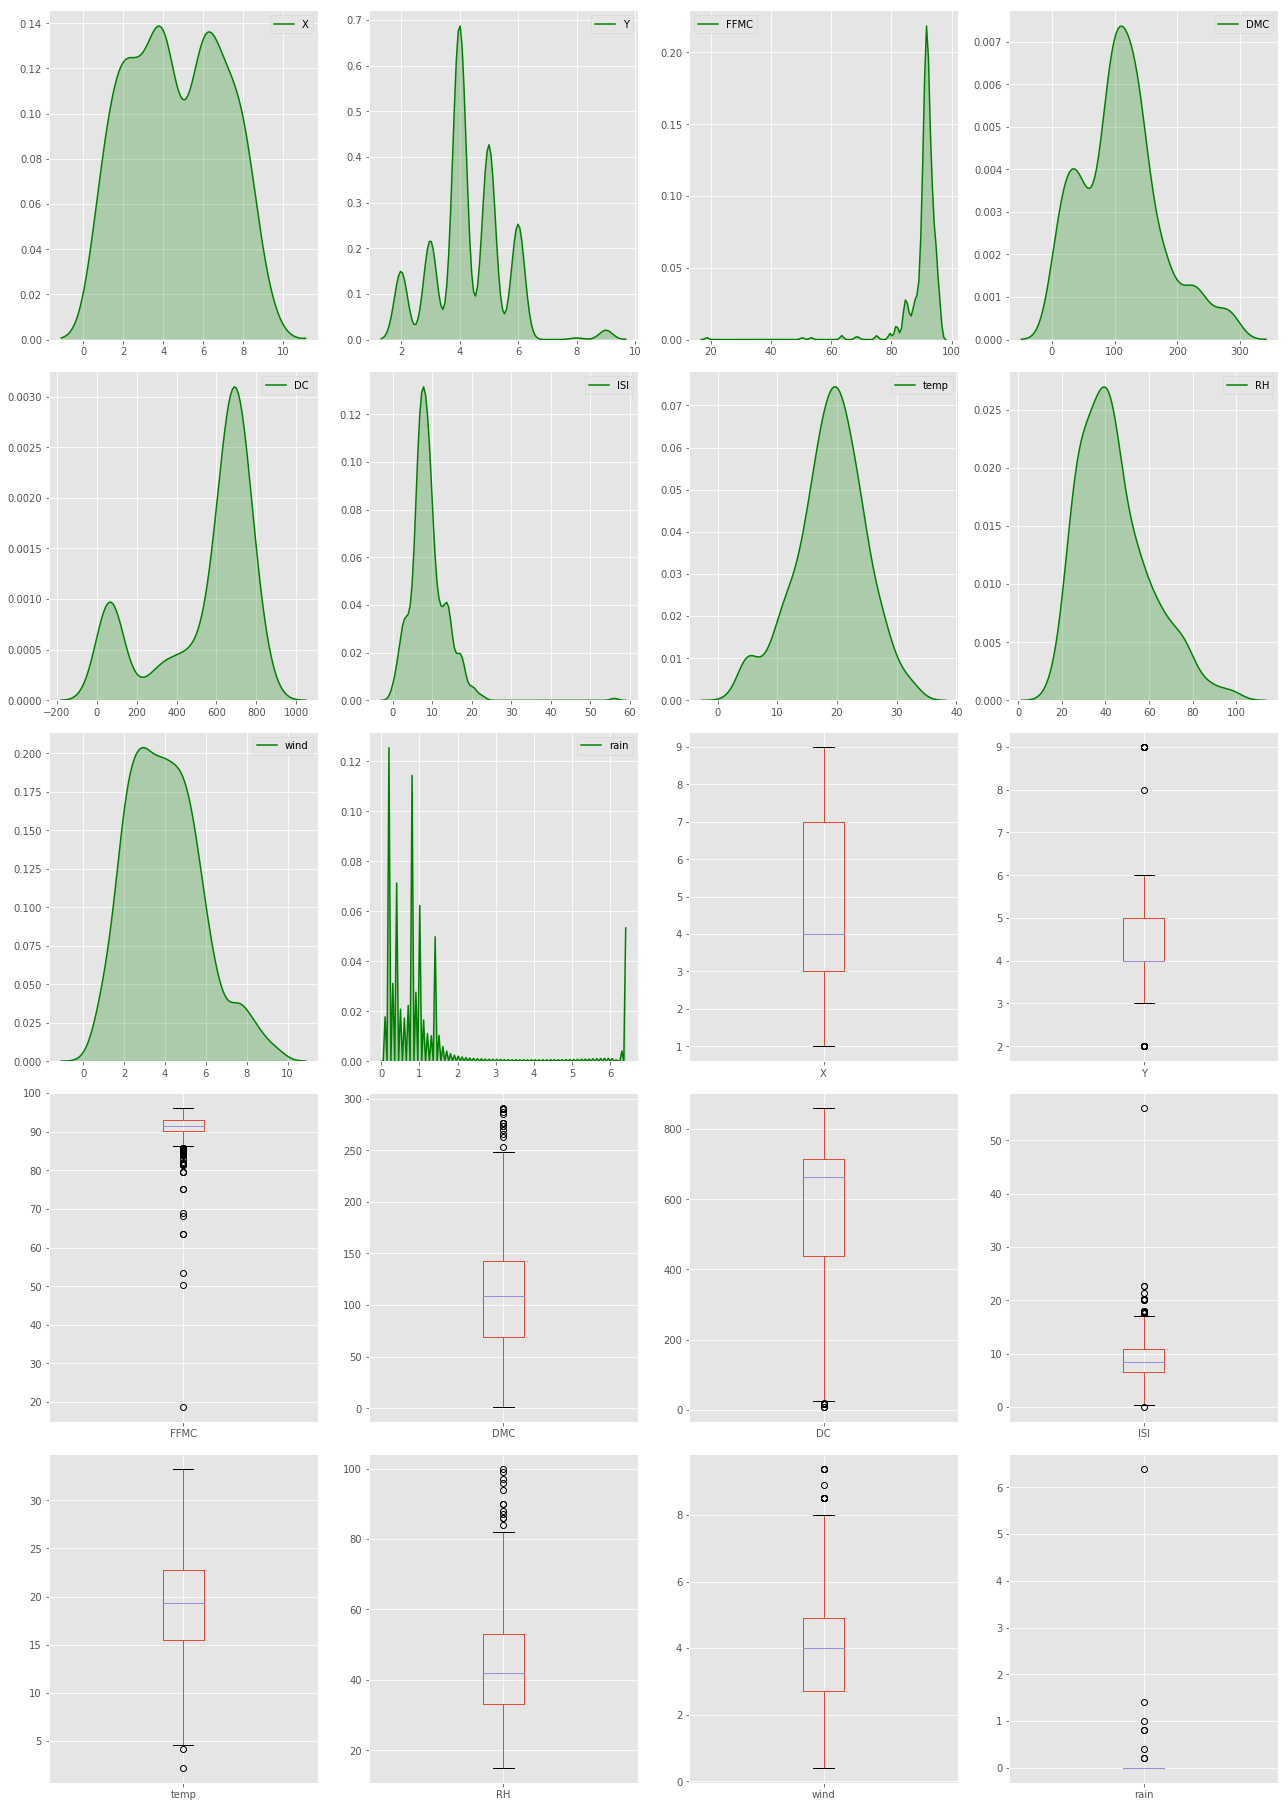

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [13]:
#Analyzing numerical variables
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

Outliers, Skewness and kurtosis (high positive or negative) was observed in the following columns:
1. FFMC
2. ISI
3. rain

# Bivariate analysis

In [6]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


In [7]:
df['damage_category'].value_counts()

No damage    247
moderate     191
high          41
low           27
very high     11
Name: damage_category, dtype: int64

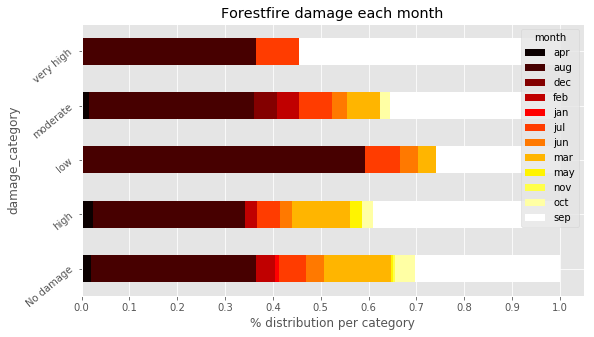

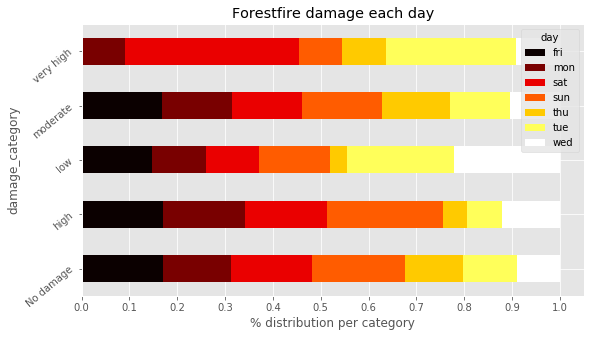

In [15]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

- Previously we had observed that `August` and `September` had the most number of forest fires. And from the above plot of `month`, we can understand few things
    - Most of the fires in August were low (< 1 hectare).
    - The very high damages(>100 hectares) happened in only 3 months - august,july and september.
 
- Regarding fire damage per day, nothing much can be observed. Except that, there were no ` very high` damaging fires on Friday and on Saturdays it has been reported most.

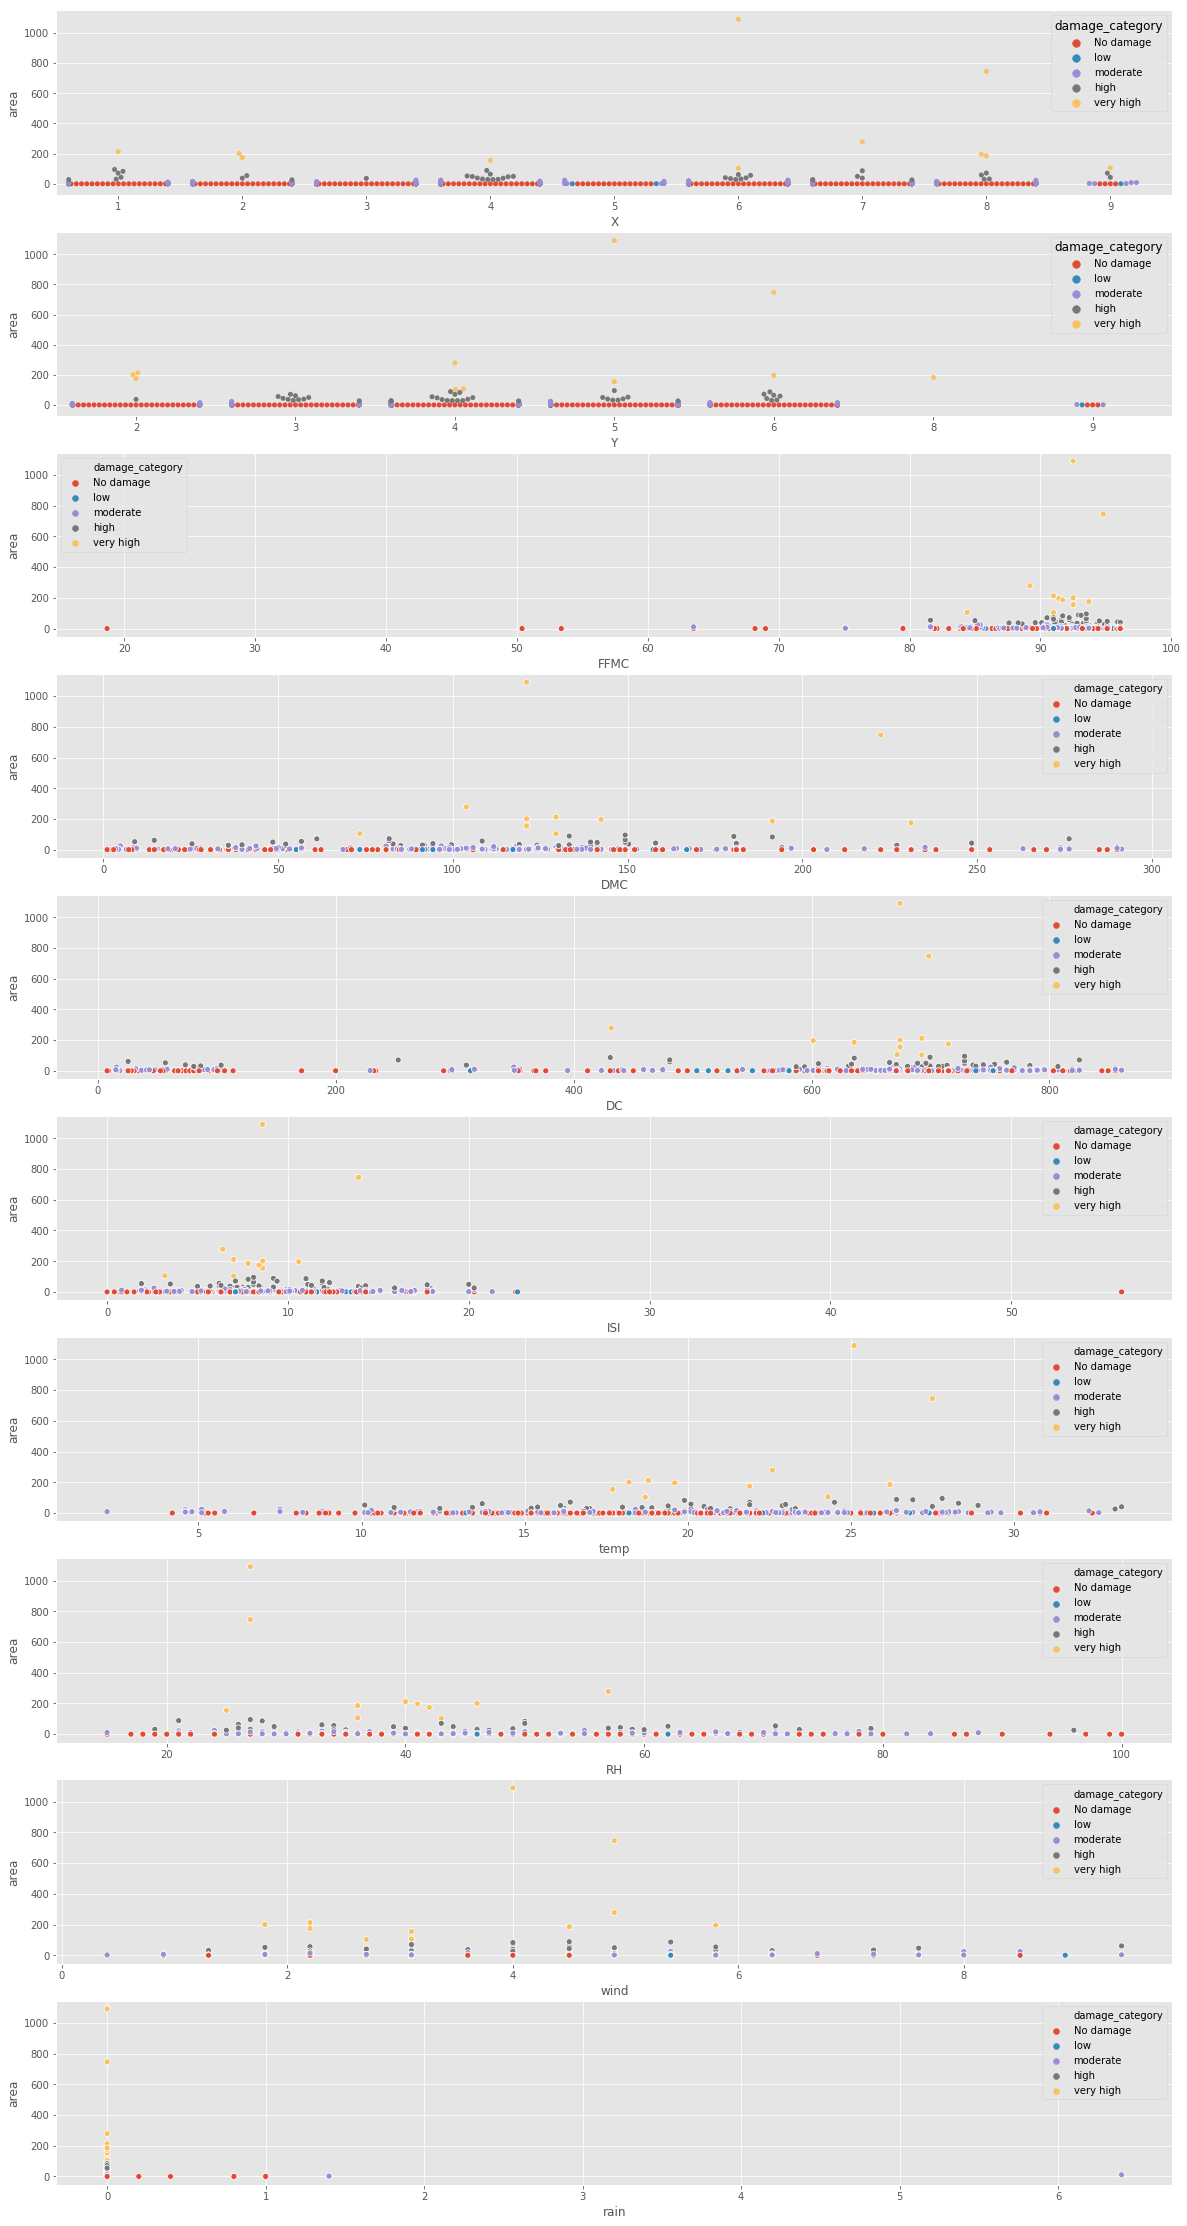

In [17]:
#Numerical COlumns
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

# Multivariate analysis

C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


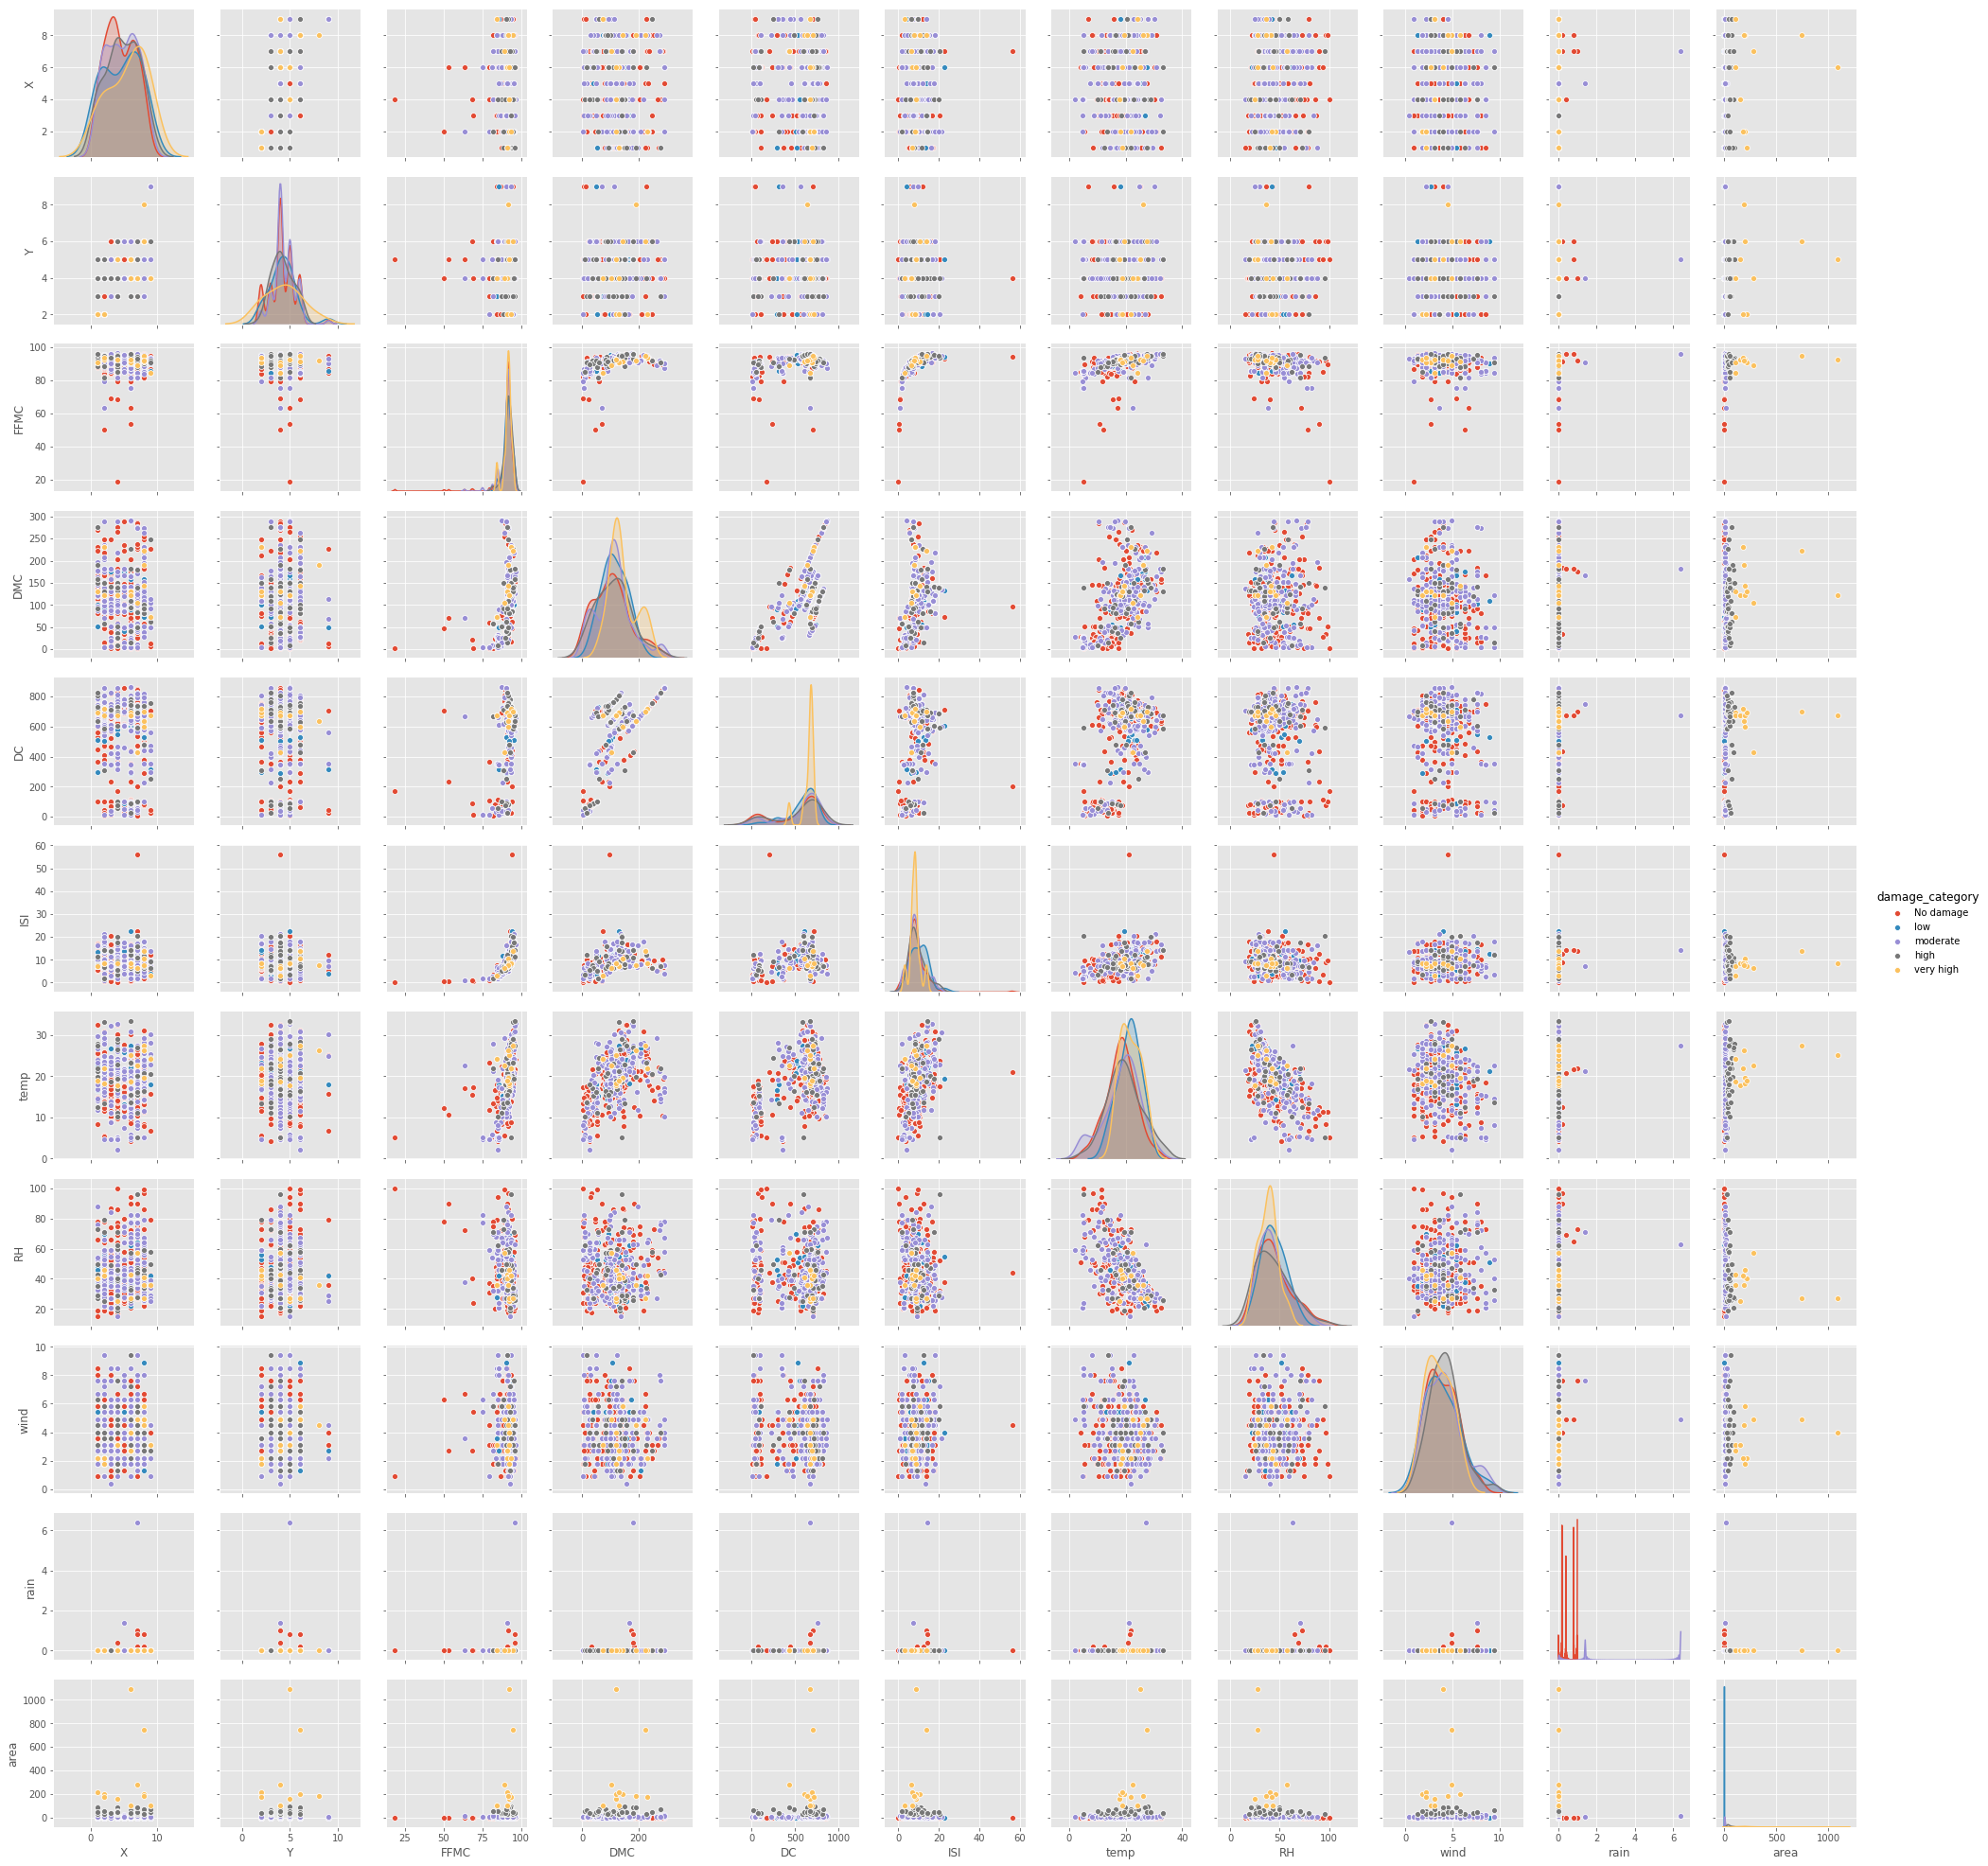

In [18]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features
sns.pairplot(df,hue='damage_category',vars=selected_features)
plt.show()

<h2>Data Cleaning</h2>

We had observed outliers in the following columns:
1. area 
2. FFMC
2. ISI
3. rain

However, the above outliers are not error values so we cannot remove it. 

In order to minimize the effect of outliers in our model we will transform the above features. 

In [19]:
out_columns = ['area','FFMC','ISI','rain']

<h2>Data Preparation</h2>

In [20]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

In [21]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [22]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [23]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [24]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

<h2>Data Modelling</h2>

<h2>Linear Regression</h2>

In [25]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [95]:
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.metrics import r2_score
from math import sqrt
lr = LinearRegression()
lr.fit(x_train, y_train) #Training

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(x_train, y_train)}')
#pd.DataFrame({"Coefficients": lr.coef_}, index=train_img.columns)

Intercept: -5.114086383709965
R^2 score: 0.11251768851275079


In [97]:
y_predict=lr.predict(x_test)
# y_predict=clf1.predict(X_test_ohe)
rms = sqrt(mean_squared_error(y_test, y_predict))
print('RMS: ',rms)

RMS:  1.544120676087026


<h2>Applying XGBOOST</h2>

In [98]:
import warnings
import xgboost as xgb
import csv as csv
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5,7,9],
   'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]
}
clf=RandomizedSearchCV(xgb.XGBRegressor(), parameters_for_testing, random_state=1, cv=20, verbose=0,scoring='r2')
# xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)
best_model = clf.fit(x_train, y_train)

[13:54:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:19] WARNI

[13:54:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:23] WARNI

[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:33] WARNI

[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:34] WARNI

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [99]:
y_predict=best_model.predict(x_test)
rms = sqrt(mean_squared_error(y_test, y_predict))
print('RMS: ',rms)

RMS:  1.5564806886827618


<h2>SVM</h2>

In [2]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
hyperparameters = dict(kernel=['linear','rbf','sigmoid'],C=[0.001,0.01,0.1,1, 10, 100, 1000],epsilon = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,1, 10, 100, 1000])
clf=RandomizedSearchCV(SVR(), hyperparameters, random_state=1, cv=10, verbose=0,scoring='r2')
best_model = clf.fit(x_train, y_train)
y_predict=   best_model.predict(x_test)
rms = sqrt(mean_squared_error(y_test, y_predict))
print('RMS: ',rms)

RMS:  1.2457765789435


In [3]:
#SVM is giving best RMSE value of 1.24